In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import csv

In [2]:
stations = pd.read_csv('./seoul_boarding_pop_by_subway.csv').station
lines = pd.read_csv('./seoul_boarding_pop_by_subway.csv').line

In [3]:
objects = pd.read_csv('./clustering_parameters.csv', encoding='EUC-KR')
col_names = pd.Index(['id', 'station', 'time']).append(objects.columns)
objects['station'] = [i for i in stations for _ in range(4)]
objects['line'] = [i for i in lines for _ in range(4)]
objects['id'] = objects['line'] + objects['station']
objects['time'] = ['출근', '낮', '퇴근', '밤']*len(stations)
objects.reindex(columns = col_names)


,id,station,time,20남,30남,40남,50남,6-70남,20여,30여,40여,50여,6-70여,총인원
0,1호선동대문,동대문,출근,0.084346,0.109687,0.118614,0.108097,0.096940,0.095445,0.092585,0.096034,0.091298,0.106954,96219.5
1,1호선동대문,동대문,낮,0.078076,0.115499,0.121612,0.106386,0.096039,0.099559,0.102443,0.097990,0.089632,0.092764,159446.0
2,1호선동대문,동대문,퇴근,0.093400,0.114311,0.116277,0.102721,0.089916,0.111701,0.097666,0.093950,0.086836,0.093221,111656.5
3,1호선동대문,동대문,밤,0.106137,0.101975,0.101291,0.096518,0.096830,0.110825,0.086980,0.092930,0.091539,0.114974,51192.5
4,1호선동묘앞,동묘앞,출근,0.082899,0.111753,0.120837,0.108905,0.095663,0.094964,0.094083,0.096291,0.090433,0.104172,48756.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,경의중앙선중랑,중랑,밤,0.081408,0.096055,0.096391,0.102579,0.108183,0.081795,0.092430,0.099016,0.111009,0.131134,20504.5
1500,경의중앙선회기,회기,출근,0.105151,0.091747,0.092119,0.091117,0.108167,0.100703,0.088410,0.091459,0.097746,0.133379,215938.5
1501,경의중앙선회기,회기,낮,0.102674,0.086874,0.090480,0.092471,0.114312,0.096767,0.084797,0.091958,0.099483,0.140184,235599.0
1502,경의중앙선회기,회기,퇴근,0.101738,0.089209,0.092658,0.093686,0.113323,0.095502,0.085722,0.091835,0.099382,0.136944,222342.0


In [4]:
twenties = ['20남', '30남', '20여', '30여']
sixties = ['6-70남', '6-70여']
t = s = 0
for idx in objects.index:
    total = objects.at[idx, '총인원']
    for twenty in twenties:
        t += objects.at[idx, twenty] * total
    for sixty in sixties:
        s += objects.at[idx, sixty] * total
slope = s/t
slope

0.5245841559724013

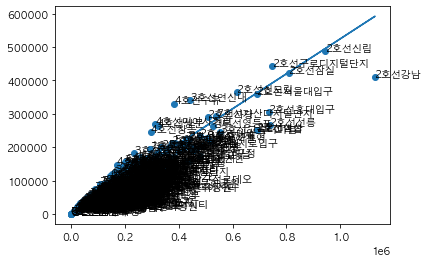

In [5]:
# 20-30대 승하차인원 vs 60-70대 승하차인원
# 시간대 합침

twenties = ['20남', '30남', '20여', '30여']
sixties = ['6-70남', '6-70여']
def func(x):
    d = {}
    d['twenties'] = (x[twenties].sum(axis=1)*x['총인원']).sum()
    d['sixties'] = (x[sixties].sum(axis=1)*x['총인원']).sum()
    return pd.Series(d, index=['twenties', 'sixties'])

df = objects.groupby(['id']).apply(func)
x = df['twenties']
y = df['sixties']
df = df.reset_index()

plt.rc('font', family='AppleGothic')        
plt.scatter(x, y)
plt.plot(x, x*slope)
for i, txt in enumerate(df.id):
    plt.annotate(txt, (x[i], y[i]))
plt.show()

In [6]:
below = {} # 20대가 더 많음
above = {} # 30대가 더 많음
for x, y, station in zip(df['twenties'], df['sixties'], df['id']):
    _y = slope*x
    if _y > y:
        below[station] = _y - y
    else:
        above[station] = y - _y

above = sorted(above.items(), key=(lambda x: x[1]), reverse=True)
below = sorted(below.items(), key=(lambda x: x[1]), reverse=True)
print([x[0] for x in above[:10]])
print([x[0] for x in below[:10]])


['4호선수유', '3호선연신내', '4호선미아사거리', '4호선쌍문', '4호선창동', '3호선구파발', '4호선미아', '2호선구로디지털단지', '3호선불광', '6호선응암']
['2호선강남', '2호선선릉', '2호선역삼', '2호선삼성', '2호선홍대입구', '3호선압구정', '3호선신사', '9호선신논현', '7호선학동', '1호선서울역']


In [7]:
floating = pd.read_csv('./skt_floating_pop.csv')

floating = floating.drop('datetime', axis=1).groupby(['gu', 'hour', 'age', 'sex']).sum().reset_index()
pop_by_gu = floating.drop('age', axis=1).groupby(['gu', 'hour']).sum('floating_pop').reset_index()

def get_percentage(gu, hour, floating_pop):
    total = pop_by_gu[(pop_by_gu.gu==gu)&(pop_by_gu.hour==hour)].floating_pop.values[0]
    return floating_pop/total

floating['percentage'] = floating.apply(lambda x: get_percentage(x.gu, x.hour, x.floating_pop), axis=1)
floating

,gu,hour,age,sex,floating_pop,percentage
0,강남구,0,20,남성,1109500,0.082722
1,강남구,0,20,여성,1213790,0.090498
2,강남구,0,30,남성,1426850,0.106384
3,강남구,0,30,여성,1525440,0.113734
4,강남구,0,40,남성,1460120,0.108864
...,...,...,...,...,...,...
7195,중랑구,23,50,여성,1058600,0.110069
7196,중랑구,23,60,남성,622840,0.064760
7197,중랑구,23,60,여성,679680,0.070670
7198,중랑구,23,70,남성,400120,0.041603


In [8]:
import re

boarding = pd.read_csv('./seoul_boarding_pop_by_subway.csv')
def repl(name):
    if "승차" in name:
        return str(int(name.split("-")[0].replace("시", "")))+"_승차"
    else:
        return str(int(name.split("-")[0].replace("시", "")))+"_하차"
    
boarding = boarding.rename(columns={col: repl(col) for col in boarding.columns[3:-3]})
boarding['total'] = 0
for i in range(0, 24):
    boarding[i] = boarding[str(i)+"_승차"]+boarding[str(i)+"_하차"]
    boarding = boarding.drop([str(i)+"_승차", str(i)+"_하차"], axis=1)
    boarding['total'] += boarding[i]
boarding

,datetime,line,station,작업일자,ID,gu,total,0,1,2,...,14,15,16,17,18,19,20,21,22,23
0,202009,1호선,동대문,20201003,1호선동대문,종로구,558430,875,2,3,...,37624,37969,37434,37773,37549,32853,23235,19571,15465,11302
1,202009,1호선,동묘앞,20201003,1호선동묘앞,종로구,465297,1170,0,1,...,49178,48110,42597,35952,30246,15412,8775,7766,5429,3095
2,202009,1호선,서울역,20201003,1호선서울역,중구,1700946,514,0,0,...,76479,88738,94704,148813,201269,109309,71421,64971,39697,16921
3,202009,1호선,시청,20201003,1호선시청,중구,850882,65,0,0,...,33660,37369,40157,69251,120378,46833,33463,31476,16356,5589
4,202009,1호선,신설동,20201003,1호선신설동,동대문구,634373,362,3,0,...,32215,35142,39427,52701,71945,35216,21500,19270,12930,6739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,202009,경의중앙선,망우,20201003,경의중앙선망우,중랑구,353828,905,0,0,...,17107,19202,21631,25045,34254,24275,16028,11845,9430,5170
372,202009,경의중앙선,상봉,20201003,경의중앙선상봉,중랑구,278612,1351,0,0,...,12017,13660,14245,18193,27781,23111,13981,11455,9606,4776
373,202009,경의중앙선,양원,20201003,경의중앙선양원,중랑구,76830,132,0,0,...,3783,5579,5903,5679,5781,3787,2449,1741,1416,672
374,202009,경의중앙선,중랑,20201003,경의중앙선중랑,중랑구,256807,692,0,0,...,12186,13891,14291,17357,25176,16765,12276,10387,6749,3623


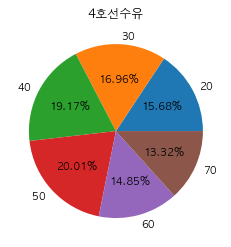

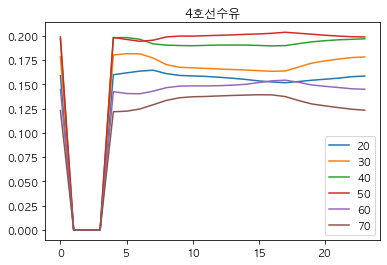

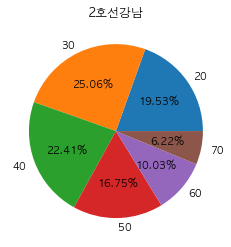

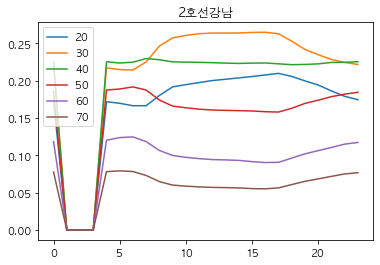

In [9]:
_above = [x[0] for x in above[:1]]
_below = [x[0] for x in below[:1]]
age = floating.age.unique()
sex = floating.sex.unique()

for _id in _above+_below:
    boarding_pop = boarding[(boarding.ID==_id)]
    gu = boarding_pop.gu.values[0]
    floating_pop = floating[floating.gu==gu].reset_index()
    floating_pop['estimated'] = floating_pop.apply(lambda x: boarding_pop[x.hour]*x.percentage, axis=1)    
    floating_pop['id'] = _id
    data = floating_pop.groupby(['age', 'hour']).sum('estimated')
#     PIE CHART
    pie_chart = data.groupby(['age']).sum('estimated')
    plt.pie(pie_chart.estimated.values, 
            labels=pie_chart.index.values,
           autopct='%1.2f%%',
           )
    plt.title(_id)
    plt.show()

#     연령 + 시간대별 승하차 비율
    x = np.arange(0, 24)
    boarding_total_by_hour = boarding_pop[range(0, 24)].replace([0], 0.1)
    for a in age:
        y = (data.loc[a, 'estimated']/boarding_total_by_hour).iloc[0]
        plt.plot(x, y, label=a)
    plt.legend()
    plt.title(_id)
    plt.show()
        

